<a href="https://colab.research.google.com/github/sush104/Crisis_Event_Ranking_and_Summarization/blob/main/CrisisFACTs_Sushant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: Contextual fact ranking, and summarization using word embedding for emergency responders  - Show

This notebook demonstrate the different techniques used for Crisis Fact ranking and summarization. Here I am using TREC 2022 CrisisFACTS datasets provided by TREC

**Installing Needed Packages**

We need to install a few packages before we can access the data to handle the download process and enable detailed analysis that will be done later in this project. We're going to install below packages:


*   ir_datasets (https://github.com/allenai/ir_datasets): A Python tool gives users access to numerous IR ad hoc ranking benchmarks, training datasets, etc., through a standard interface. We can extract the raw event streams and data required for each.
*   pyTerrier (https://pyterrier.readthedocs.io/en/latest/): The Terrier IR Platform has a Python wrapper called pyTerrier developed by many researchers at the University of Glasgow. During a crisis, we'll utilise this to create a searchable index for each day so we can retrieve relevant documents for different information needs.



In [ ]:
!pip install -q git+https://github.com/allenai/ir_datasets.git@crisisfacts # install ir_datasets (crisisfacts branch)
!pip install -q python-terrier # install pyTerrier

     |████████████████████████████████| 1.2 MB 4.8 MB/s 
     |████████████████████████████████| 72 kB 1.2 MB/s 
     |████████████████████████████████| 126 kB 46.5 MB/s 
     |████████████████████████████████| 294 kB 49.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 97 kB 2.7 MB/s 
     |████████████████████████████████| 1.1 MB 40.1 MB/s 
     |████████████████████████████████| 69 kB 6.8 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 45 kB 2.6 MB/s 
     |████████████████████████████████| 285 kB 56.0 MB/s 


**Import required libraries** 

In [ ]:
import pandas as pd
import json
import pyterrier as pt
import ir_datasets
from urllib.request import urlopen
import gensim.downloader as api
import json
import numpy as np

**Initalizing Credentials**

When you want to download part of the CrisisFACTs dataset we require that you provide a set of contact details. The reason for this is two-fold: 1) the terms of service from some of the platforms (like Twitter) from which we have sourced data require us to do so, and 2) it allows us to collect statistics on how many people are making use of the data we provide.

**GDPR Statement**: By downloading the CrisisFACTs datasets, you agree to the University of Glasgow processing your personal data, as defined by the EU General Data Protection Regulation (GDPR) - your name and email in this case. Queries about data processing and access/deletion requests should be sent to [me via email](http://www.dcs.gla.ac.uk/~richardm/Home/Contact.html). We will store your data for as long as the track is on-going and up-to 2 years beyond that. I may contact you using the details provided to notify you about changes in the datasets or track, to provide information or ask you questions about your participation or otherwise contact you about topics relevant to emergency management. We may collate statistics from the provided information that will be published, but we will not release individual names or email addresses. 

Rather than entering these details every time you request the dataset, its more effcient to set this once up-front, so fill in your details below:

In [ ]:
credentials = {
    "institution": "University of Glasgow", # University, Company or Public Agency Name
    "contactname": "Sushant Shelke", # Your Name
    "email": "2642782s@student.gla.ac.uk", # A contact email address
    "institutiontype": "Research" # Either 'Research', 'Industry', or 'Public Sector'
}

# Write this to a file so it can be read when needed
!mkdir -p /root/.ir_datasets/auth/
with open('/root/.ir_datasets/auth/crisisfacts.json', 'w') as f:
    json.dump(credentials, f)

**The CrisisFACTs Dataset structure**

The events in the CrisisFACTs collection correspond to real crises. Each event has a unique identification number, such as "CrisisFACTS-001" for the 2017 Lilac Wildfire. The following three digits of the event identifier, such as "001, 002, 003", are the event number, which we refer to as "eventNo." The following eight events make up CrisisFACTs 2022:

In [ ]:
eventNoList = [
          "001", # Lilac Wildfire 2017
          "002", # Cranston Wildfire 2018
          "003", # Holy Wildfire 2018
          "004", # Hurricane Florence 2018
          "005", # 2018 Maryland Flood
          "006", # Saddleridge Wildfire 2019
          "007", # Hurricane Laura 2020
          "008" # Hurricane Sally 2020
]

**Get list of days for each event**

Each event has a duration, i.e. it lasts for several days. Therefore, we have event-day pair in the dataset. I am getting the list of days from event-day pairs.Each event has a duration, i.e. it lasts for a number of days. In the CrisisFACTs track, you need to produce a timeline summary for each day for a set of events. You can get the list of days for an event as shown below (example is for event "001", i.e. the Lilac Wildfire 2017):

In [ ]:
# Gets the list of days for a specified event number, e.g. '001'
def getDaysForEventNo(eventNo):

  #construct URL for downloading the JSOn data
  url = "http://trecis.org/CrisisFACTs/CrisisFACTS-"+eventNo+".requests.json"

  # Download JSON data
  dayList = json.loads(urlopen(url).read())

  return dayList

The data is collected from Twitter Tweets, Reddit and Facebook posts, and news articles available from online data sources.

We reorganised this data into a list of standardised "stream items" because these sources differ in their formatting and properties. A stream item has the following information.


*   **event**: The identifier of the event, e.g. 'CrisisFACTS-001'
*   **streamID**: A unique identifier for the stream item. This will generally be of the form 'CrisisFACTS-\<eventNo\>-\<source\>-\<postID\>-\<sentenceID\>', e.g. CrisisFACTS-001-Twitter-15712-0.
*   **unixTimestamp**: This is the time that the content was originally posted, expressed as a unix timestamp in seconds (UTC timezone).
*   **text**: The text of the stream item. The maximum length of a stream item is 200 characters. 
*   **sourceType**: A string denoting the source, i.e. either Twitter, Reddit, News or Facebook.
*   **source**: This is the original post content formated as JSON.

Since, some types of content are longer than others (compare a news article vs. a tweet for instance), for long-form content we perform sentence segmentation, so one input post might form multiple stream items. In these cases, the 'sentenceID' component of the streamID denotes the number of the sentence in the source content.


The dataset can be access by creating a string as shown below:

*   '**crisisfacts/\<eventNo\>/\<day\>**'

:

In [ ]:

cols = ["Event", "Facts_Date", "Requist_ID"]
stream_df = pd.DataFrame(columns = cols)

for eventNo in eventNoList: # for each event
  dayList = getDaysForEventNo(eventNo) # get the list of days
  for day in dayList: # for each day
    stream_df = stream_df.append({'Event': "Event "+eventNo, 'Facts_Date':"crisisfacts/"+eventNo+"/"+day["dateString"], 'Requist_ID':day["requestID"]},ignore_index=True)

In [ ]:
eventsMeta = {}

for eventNo in eventNoList: # for each event
    dailyInfo = getDaysForEventNo(eventNo) # function call for getting list of days
    eventsMeta[eventNo]= dailyInfo
    
    print("Event "+eventNo)
    for day in dailyInfo: # for each day
        print("  crisisfacts/"+eventNo+"/"+day["dateString"], "-->", day["requestID"]) # construct the request string

Event 001
  crisisfacts/001/2017-12-07 --> CrisisFACTS-001-r3
  crisisfacts/001/2017-12-08 --> CrisisFACTS-001-r4
  crisisfacts/001/2017-12-09 --> CrisisFACTS-001-r5
  crisisfacts/001/2017-12-10 --> CrisisFACTS-001-r6
  crisisfacts/001/2017-12-11 --> CrisisFACTS-001-r7
  crisisfacts/001/2017-12-12 --> CrisisFACTS-001-r8
  crisisfacts/001/2017-12-13 --> CrisisFACTS-001-r9
  crisisfacts/001/2017-12-14 --> CrisisFACTS-001-r10
  crisisfacts/001/2017-12-15 --> CrisisFACTS-001-r11

Event 002
  crisisfacts/002/2018-07-25 --> CrisisFACTS-002-r1
  crisisfacts/002/2018-07-26 --> CrisisFACTS-002-r2
  crisisfacts/002/2018-07-27 --> CrisisFACTS-002-r3
  crisisfacts/002/2018-07-28 --> CrisisFACTS-002-r4
  crisisfacts/002/2018-07-29 --> CrisisFACTS-002-r5
  crisisfacts/002/2018-07-30 --> CrisisFACTS-002-r6

Event 003
  crisisfacts/003/2018-08-06 --> CrisisFACTS-003-r5
  crisisfacts/003/2018-08-07 --> CrisisFACTS-003-r6
  crisisfacts/003/2018-08-08 --> CrisisFACTS-003-r7
  crisisfacts/003/2018-08-09 -

##Initialize pyTerrier library - Show


In [ ]:
# Initalize pyTerrier if not started
if not pt.started():
  pt.init()

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.8.1 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



# Functions declaration and loading pretained model

In [ ]:
#Pre-trained model
%time model = api.load("glove-twitter-25")
# %time model = api.load("word2vec-google-news-300")


[==================================================] 100.0% 104.8/104.8MB downloaded
CPU times: user 1min 2s, sys: 4.1 s, total: 1min 6s
Wall time: 1min 33s


In [ ]:
#Word2Vec Function 
def word2vec_func(query_set):
  words = set(query_set["query"].to_string(index=False).split())
  # print(query_set["query"])
  query_variations = ""
  count = 0

  for element in words:# for each word
    if element in model.vocab.keys() and element.isalnum():  
        m_similar = dict(model.most_similar(element)) #getting most_similar words

        for element in model.vocab.keys() and m_similar.keys():#for each word in vocab
          if(element.isalnum()):
            query_variations += " " + str(element)     
            count+=1           

  query_set["query"] += query_variations
  query_set["score"] += (count*0.1)/len(words)
  # print(query_set["score"])
  # print(query_set["query"])
  # print("\n")

  return(query_set)

In [ ]:
#Index Creation for each dataset at a time

def create_index(dataset):
  
    #Download dataset using head given by ir_dataset as 'irds:'
    pyTerrierDataset = pt.get_dataset('irds:'+dataset)

    # Index creation using indexer
    indexer = pt.index.IterDictIndexer("None", type=pt.index.IndexingType(3), meta=['docno', 'text'], meta_lengths=[40, 200])
    index_ref = indexer.index(pyTerrierDataset.get_corpus_iter(), meta=('docno', 'text',))

    #Creating an index
    index = pt.IndexFactory.of(index_ref)
    topics = pyTerrierDataset.get_topics(variant='indicative_terms')
    
    return index

In [ ]:
#FUnction for retrieval model
def Retriver_model(index, model):#model is name of statistical function
    retriever = pt.BatchRetrieve(index, wmodel=model, metadata=["docno", "text"])
    return retriever

In [ ]:
#Function to find the affected documents for given query
def  get_quries_hits(retriever, queries):
    
    event_queries={}
    event_scores={}
    
    for index, query in queries.iterrows():
        # topics = pyTerrierDataset.get_topics(variant='indicative_terms')
        results = pd.DataFrame(retriever.transform(query['indicative_terms']))#query as indicative term from query dataset
        
        for ind, result in results.iterrows():
            if result['docno'] in event_queries:
                event_queries[result['docno']].append(query['query_id'])
                event_scores[result['docno']].append(result['score'])
            else:
                event_queries[result['docno']]=[query['query_id']]
                event_scores[result['docno']]=[result['score']]
    
    return event_queries,event_scores #return result of queries and score associated with it

In [ ]:
from json.decoder import JSONDecodeError
rows = []
rows_QE = []

for eventId,dailyInfo in eventsMeta.items():

    for thisDay in dailyInfo:
        
        requestID = thisDay["requestID"]
        ir_dataset_id = "crisisfacts/%s/%s" % (eventId, thisDay["dateString"])  
        # print(requestID, ir_dataset_id)
        try:
          dataset = ir_datasets.load(ir_dataset_id)        
          queries = pd.DataFrame(dataset.queries_iter())

        except JSONDecodeError:
          print("Error in loading dataset",JSONDecodeError)
          continue

        index = create_index(ir_dataset_id)
        tf_idf_retriver = Retriver_model(index, "TF_IDF")
        bm25_retriver = Retriver_model(index, "BM25")
        pl2_retriever = Retriver_model(index, "PL2")


        ##Query Expansion
        bo1 = bm25_retriver >> pt.rewrite.Bo1QueryExpansion(index) >> bm25_retriver
        # klq = pt.rewrite.KLQueryExpansion(index)

        # retriever = pt.BatchRetrieve(index, wmodel="DFReeKLIM", metadata=["docno", "text"])
        pipelineQE = (bm25_retriver % 100) >> bo1 >> (bm25_retriver % 100)
        # after_QE = pd.DataFrame(pipelineQE.transform("airport closed"))
        event_queries_QE, event_scores_QE = get_quries_hits(pipelineQE,queries)
        #END QExp

        #Multistage Retrieval
        pipe = bm25_retriver >> (pt.transformer.IdentityTransformer() ** tf_idf_retriver ** pl2_retriever)
        #END Multistage Retrieval
        
        ##Query Embedding
        final_model =  Embedding >> pt.apply.by_query(word2vec_func) >> bm25_retriver

        event_queries, event_scores = get_quries_hits(final_model,queries)
        ##END QEmb

        itemsAsDataFrame = pd.DataFrame(dataset.docs_iter())

        #For loop for QE to create final JSON data
        for key,value in event_scores_QE.items():
            fact = itemsAsDataFrame.query(f"doc_id== '{key}'").iloc[0]
            
            rows_QE.append({
                'requestID' : requestID, 
                'factText' : fact["text"], 
                'unixTimestamp' : fact["unix_timestamp"],
                "importance" : np.sum(value),
                "sources" : [key],
                "streamID" : key,
                "informationNeeds" : event_queries_QE[key]
            })
           
        ##QE for END
        ##For loop for W2V to create final JSON data
        for key,value in event_scores.items():
            fact = itemsAsDataFrame.query(f"doc_id== '{key}'").iloc[0]
            
            rows.append({
                'requestID' : requestID, 
                'factText' : fact["text"], 
                'unixTimestamp' : fact["unix_timestamp"],
                "importance" : np.sum(value),
                "sources" : [key],
                "streamID" : key,
                "informationNeeds" : event_queries[key]
            })
        ##W2V for END 
    #     break
    # break
output_QE = pd.DataFrame(rows_QE)
output = pd.DataFrame(rows)

[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [7.15s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.50s]
docs_iter: 7288doc [00:20, 358.68doc/s]
[INFO] [finished] docs_iter: [00:20] [7288doc] [358.66doc/s]
[INFO] [finished] building docstore [20.33s]


crisisfacts/001/2017-12-07 documents: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: specifying meta and meta_lengths in IterDictIndexer.index() is deprecated, use constructor instead
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pyterrier/datasets.py:435: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)
/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:887: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  topics = m.transform(topics)


15:26:21.368 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


#Thresh-Hold Setting and Result Generation

In [ ]:
#Function for manually setting thresh-hold, selecting top n documents, and calculating the arrangement by the most important document
def setThreshold(outputDF, thValue, topn):
  outputDF['max'] = outputDF.groupby('requestID')['importance'].transform('max')#groupby requestID

  outputDF = outputDF.sort_values(["max","importance"], ascending=False).drop('max', axis=1)

  outputDF = outputDF.loc[outputDF["importance"] > thValue].groupby("requestID").head(topn)#Select top n document after setting given thresh-hold

  return outputDF

In [ ]:
#Dumping data into JSON file
def JSONFileCreation(dataframe, name):
    dataframe.to_json("./"+name+".json", orient="records", lines=True)
    
    return "File created sucessfully"

In [ ]:
# thOutput_QE = setThreshold(output_QE, 2, 64)
thOutput_w2v = setThreshold(output, 45, 64)

**Tried but not applied in final ranking**

In [ ]:
#Trial for automatic thresh-hld setting 
# def threshHoldCalculation(dataframe):
#   threashHolddf = pd.DataFrame()
#   threashHolddf["ThreshHold"] = dataframe.requestID
#   threashHolddf["importance"] = dataframe.importance

#   return pd.DataFrame(threashHolddf.groupby("ThreshHold")["importance"].mean())

**Above section ends here**

**Calling function to create JSON file**

In [ ]:
JSONFileCreation(output_QE,"Submission_sushant_QE")

'File created sucessfully'

In [ ]:
JSONFileCreation(thOutput_w2v,"Submission_sushant_W2V")

'File created sucessfully'

**Reading the craeted JSON files fir further evaluation**

In [ ]:
submission_df_QE = pd.read_json("./Submission_sushant_QE.json", orient="records", lines=True)

In [ ]:
submission_df_W2V = pd.read_json("./Submission_sushant_W2V.json", orient="records", lines=True)

In [ ]:
submission_df_W2V

,requestID,factText,unixTimestamp,importance,sources,streamID,informationNeeds
0,CrisisFACTS-004-r8,"If flooding and other damage are bad, then you...",1535795913,136.802323,[CrisisFACTS-004-Reddit-s3590-c3492-12],CrisisFACTS-004-Reddit-s3590-c3492-12,"[CrisisFACTS-General-q003, CrisisFACTS-General..."
1,CrisisFACTS-004-r8,"We have food, water, and emergency shelter Inc...",1535795913,103.504789,[CrisisFACTS-004-Reddit-s3590-c2460-2],CrisisFACTS-004-Reddit-s3590-c2460-2,"[CrisisFACTS-General-q003, CrisisFACTS-General..."
2,CrisisFACTS-004-r8,Expect significant impacts to ability to trave...,1535795913,101.976197,[CrisisFACTS-004-Reddit-s3590-c4535-3],CrisisFACTS-004-Reddit-s3590-c4535-3,"[CrisisFACTS-General-q003, CrisisFACTS-General..."
3,CrisisFACTS-004-r8,Even if you have to resort to emergency shelte...,1535795913,96.906056,[CrisisFACTS-004-Reddit-s3590-c2527-2],CrisisFACTS-004-Reddit-s3590-c2527-2,"[CrisisFACTS-General-q006, CrisisFACTS-General..."
4,CrisisFACTS-004-r8,I use bottled water for drinking and will also...,1535795913,91.377548,[CrisisFACTS-004-Reddit-s3590-c5253-2],CrisisFACTS-004-Reddit-s3590-c5253-2,"[CrisisFACTS-General-q003, CrisisFACTS-General..."
...,...,...,...,...,...,...,...
1731,CrisisFACTS-004-r11,This means more flooding and wind damage penet...,1536332388,46.596718,[CrisisFACTS-004-News-31-35],CrisisFACTS-004-News-31-35,"[CrisisFACTS-General-q011, CrisisFACTS-General..."
1732,CrisisFACTS-004-r11,"Not on the east coast, but: After Harvey I ke...",1536350003,46.320133,[CrisisFACTS-004-Reddit-s3502-c4-0],CrisisFACTS-004-Reddit-s3502-c4-0,"[CrisisFACTS-General-q003, CrisisFACTS-General..."
1733,CrisisFACTS-004-r11,"Drink water from bottles, but fill your bathtu...",1536350003,45.694980,[CrisisFACTS-004-Reddit-s3502-c39-2],CrisisFACTS-004-Reddit-s3502-c39-2,"[CrisisFACTS-General-q003, CrisisFACTS-General..."
1734,CrisisFACTS-002-r6,The California Office of Emergency Services sa...,1532913082,59.809152,[CrisisFACTS-002-News-68-16],CrisisFACTS-002-News-68-16,"[CrisisFACTS-General-q025, CrisisFACTS-General..."


**Trail section for nautomatic thresh-hold calculation but not in use of this project**

In [ ]:
threshHoldCalculation(submission_df_W2V)

,importance
ThreshHold,
CrisisFACTS-001-r10,58.632971
CrisisFACTS-001-r11,53.329105
CrisisFACTS-001-r3,67.952277
CrisisFACTS-001-r4,69.407093
CrisisFACTS-001-r5,54.304045
CrisisFACTS-001-r6,55.742308
CrisisFACTS-001-r7,58.160024
CrisisFACTS-001-r8,54.203944
CrisisFACTS-001-r9,55.902250


**Trail section ends here**

In [ ]:
#Function for generating the summary of facts by joinung all the facts text.
def summaryGenerator(dataframe, topn):
  for reqId, group in dataframe.groupby("requestID"):
    # print(reqId, group.shape[0])
    summary = " | ".join(group.sort_values(by="importance", ascending=False)["factText"])
    
    return summary

#Building ground truths JSON file into dataframe for training purpose - Show

Mounting google drive to get the golden copy of events streams summary provided

**PS: Place the "CrisisFACTs-2022.json" in the google drive and then processed**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root_path = 'drive/My Drive/Project_2022/'


Mounted at /content/drive


In [ ]:
import json 
import pandas as pd 
from pandas.io.json import json_normalize

with open(root_path +'CrisisFACTs-2022.json') as f:
    d = json.load(f)

In [ ]:
#Destructureing the golden copy
rows = []

for item in d:
    event = item['event']
    eventID = item['eventID'] 

    for req in item['summaryRequests']:
        requestID = req['requestID']

        for req_desc in item['factsByRequest'][requestID]: 
            fact = req_desc['fact']
            rows.append([event, eventID, requestID, fact])

            # print(f'{event} | {eventID} | {requestID} | {fact}')

golden_df = pd.DataFrame(rows, columns=['event', 'eventID', 'requestID', 'fact']) 

In [ ]:
golden_summary_grouped = golden_df.groupby('requestID').agg(lambda x: ''.join(set(x))).reset_index()

In [ ]:
submission_df_QE_grouped = submission_df_QE.groupby('requestID').agg(lambda x: ''.join(set(x))).reset_index()
refined_golden_summary_QE_grouped = golden_summary_grouped.merge(submission_df_QE_grouped['requestID'])

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


In [ ]:
submission_df_W2V_grouped = submission_df_W2V.groupby('requestID').agg(lambda x: ''.join(set(x))).reset_index()
refined_golden_summary_W2V_grouped = golden_summary_grouped.merge(submission_df_W2V_grouped['requestID'])

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


#Evaluation Metric Creation - Show

**Installing required packages for BERTScore, BLEU and ROUGE**

In [ ]:
pip install bert-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 3.2 MB/s 
     |████████████████████████████████| 4.7 MB 10.7 MB/s 
     |████████████████████████████████| 120 kB 47.5 MB/s 
     |████████████████████████████████| 6.6 MB 41.4 MB/s 


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from bert_score import score

In [ ]:
pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=c50438da27a162663f382bf8e0b21a2d79483399a825ae9aaa85ae1b3039267f
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1'])

#Ranking evaluation for Query Expansion - Show

In [ ]:

df = []
for i in range(0,len(submission_df_QE_grouped)):
  print(submission_df_QE_grouped['requestID'][i])
  P, R, F1 = score([submission_df_QE_grouped['factText'][i]], [refined_golden_summary_QE_grouped['fact'][i]], lang='en', verbose=True)
  rscore = scorer.score(submission_df_QE_grouped['factText'][i], refined_golden_summary_QE_grouped['fact'][i])
  precision, recall, fmeasure = rscore['rouge1']
  bleu = sentence_bleu([submission_df_QE_grouped['factText'][i]], refined_golden_summary_QE_grouped['fact'][i])
  # print(f"System level P score: {P.mean():.3f}")
  # print(f"System level R score: {R.mean():.3f}")
  # print(f"System level F1 score: {F1.mean():.3f}")
  df.append({
      "requestID" : submission_df_QE_grouped['requestID'][i],
      "BERTScore F1" : f"{F1.mean():.3f}",
      "Rouge Score" : precision,
      "BLEU Score" : bleu
  })

CrisisFACTS-001-r10


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.33 seconds, 0.11 sentences/sec
CrisisFACTS-001-r11


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 8.76 seconds, 0.11 sentences/sec
CrisisFACTS-001-r3


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.30 seconds, 0.11 sentences/sec
CrisisFACTS-001-r4


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 11.21 seconds, 0.09 sentences/sec
CrisisFACTS-001-r5


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.87 seconds, 0.10 sentences/sec
CrisisFACTS-001-r6


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.75 seconds, 0.10 sentences/sec
CrisisFACTS-001-r7


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.58 seconds, 0.10 sentences/sec
CrisisFACTS-001-r8


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.47 seconds, 0.11 sentences/sec
CrisisFACTS-001-r9


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 10.34 seconds, 0.10 sentences/sec
CrisisFACTS-002-r1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.87 seconds, 0.10 sentences/sec
CrisisFACTS-002-r2


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.59 seconds, 0.10 sentences/sec
CrisisFACTS-002-r3


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.81 seconds, 0.10 sentences/sec
CrisisFACTS-002-r4


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 11.10 seconds, 0.09 sentences/sec
CrisisFACTS-002-r5


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.61 seconds, 0.10 sentences/sec
CrisisFACTS-002-r6


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.06 seconds, 0.11 sentences/sec
CrisisFACTS-003-r10


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.62 seconds, 0.10 sentences/sec
CrisisFACTS-003-r11


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 8.86 seconds, 0.11 sentences/sec
CrisisFACTS-003-r5


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.79 seconds, 0.10 sentences/sec
CrisisFACTS-003-r6


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.92 seconds, 0.10 sentences/sec
CrisisFACTS-003-r7


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.79 seconds, 0.10 sentences/sec
CrisisFACTS-003-r8


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.37 seconds, 0.11 sentences/sec
CrisisFACTS-003-r9


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 10.55 seconds, 0.09 sentences/sec
CrisisFACTS-004-r10


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.19 seconds, 0.11 sentences/sec
CrisisFACTS-004-r11


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.46 seconds, 0.11 sentences/sec
CrisisFACTS-004-r12


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.62 seconds, 0.10 sentences/sec
CrisisFACTS-004-r13


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.49 seconds, 0.11 sentences/sec
CrisisFACTS-004-r15


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.91 seconds, 0.10 sentences/sec
CrisisFACTS-004-r16


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 10.05 seconds, 0.10 sentences/sec
CrisisFACTS-004-r18


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 10.33 seconds, 0.10 sentences/sec
CrisisFACTS-004-r19


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.76 seconds, 0.10 sentences/sec
CrisisFACTS-004-r20


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 11.05 seconds, 0.09 sentences/sec
CrisisFACTS-004-r21


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.77 seconds, 0.10 sentences/sec
CrisisFACTS-004-r22


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 12.84 seconds, 0.08 sentences/sec
CrisisFACTS-004-r8


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.71 seconds, 0.10 sentences/sec
CrisisFACTS-004-r9


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 8.83 seconds, 0.11 sentences/sec
CrisisFACTS-005-r3


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.86 seconds, 0.10 sentences/sec
CrisisFACTS-005-r4


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.72 seconds, 0.10 sentences/sec
CrisisFACTS-005-r5


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.53 seconds, 0.10 sentences/sec
CrisisFACTS-005-r6


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.56 seconds, 0.10 sentences/sec
CrisisFACTS-006-r4


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.93 seconds, 0.10 sentences/sec
CrisisFACTS-006-r5


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 10.28 seconds, 0.10 sentences/sec
CrisisFACTS-006-r6


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.86 seconds, 0.10 sentences/sec
CrisisFACTS-006-r7


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.58 seconds, 0.10 sentences/sec
CrisisFACTS-007-r13


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 10.22 seconds, 0.10 sentences/sec
CrisisFACTS-007-r14


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.96 seconds, 0.10 sentences/sec
CrisisFACTS-008-r10


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 10.54 seconds, 0.09 sentences/sec
CrisisFACTS-008-r3


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.81 seconds, 0.10 sentences/sec
CrisisFACTS-008-r4


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.99 seconds, 0.10 sentences/sec
CrisisFACTS-008-r5


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.95 seconds, 0.10 sentences/sec
CrisisFACTS-008-r6


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 11.43 seconds, 0.09 sentences/sec
CrisisFACTS-008-r7


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 10.31 seconds, 0.10 sentences/sec
CrisisFACTS-008-r9


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 12.06 seconds, 0.08 sentences/sec


Saving the scores in file

In [ ]:
pd.DataFrame(df).to_csv("./df_QE.csv")

In [ ]:
pd.DataFrame(df)

,requestID,BERTScore F1,Rouge Score,BLEU Score
0,CrisisFACTS-001-r10,0.752,0.916667,0.000000e+00
1,CrisisFACTS-001-r11,0.763,0.800000,0.000000e+00
2,CrisisFACTS-001-r3,0.772,0.917023,3.681483e-08
3,CrisisFACTS-001-r4,0.778,0.901984,3.792875e-33
4,CrisisFACTS-001-r5,0.784,0.890511,4.240178e-119
5,CrisisFACTS-001-r6,0.778,0.883895,4.612286e-55
6,CrisisFACTS-001-r7,0.778,0.903704,5.037494e-88
7,CrisisFACTS-001-r8,0.778,0.864865,3.945780e-291
8,CrisisFACTS-001-r9,0.743,0.933333,1.456761e-291
9,CrisisFACTS-002-r1,0.772,0.742857,2.159836e-99


#Ranking evaluation for Word Embedding - Show

In [ ]:

df_w2v = []
for i in range(0,len(submission_df_W2V_grouped)):
  print(submission_df_W2V_grouped['requestID'][i])
  P, R, F1 = score([submission_df_W2V_grouped['factText'][i]], [refined_golden_summary_W2V_grouped['fact'][i]], lang='en', verbose=True)
  rscore = scorer.score(submission_df_W2V_grouped['factText'][i], refined_golden_summary_W2V_grouped['fact'][i])
  precision, recall, fmeasure = rscore['rouge1']
  bleu = sentence_bleu([submission_df_W2V_grouped['factText'][i]], refined_golden_summary_W2V_grouped['fact'][i])
  # print(f"System level P score: {P.mean():.3f}")
  # print(f"System level R score: {R.mean():.3f}")
  # print(f"System level F1 score: {F1.mean():.3f}")
  df_w2v.append({
      "requestID" : submission_df_W2V_grouped['requestID'][i],
      "BERTScore F1" : f"{F1.mean():.3f}",
      "Rouge Score" : precision,
      "BLEU Score" : bleu
  })

Saving the scores in file

In [ ]:
pd.DataFrame(df_w2v).to_csv("./df_w2v.csv")

#Evaluation Graph Ploting - Show

In [ ]:
dataw2v = pd.read_csv("./df_w2v.csv")

In [ ]:
dataqe = pd.read_csv("./df_QE.csv")

**Graphs generated from above raw file are available in report**

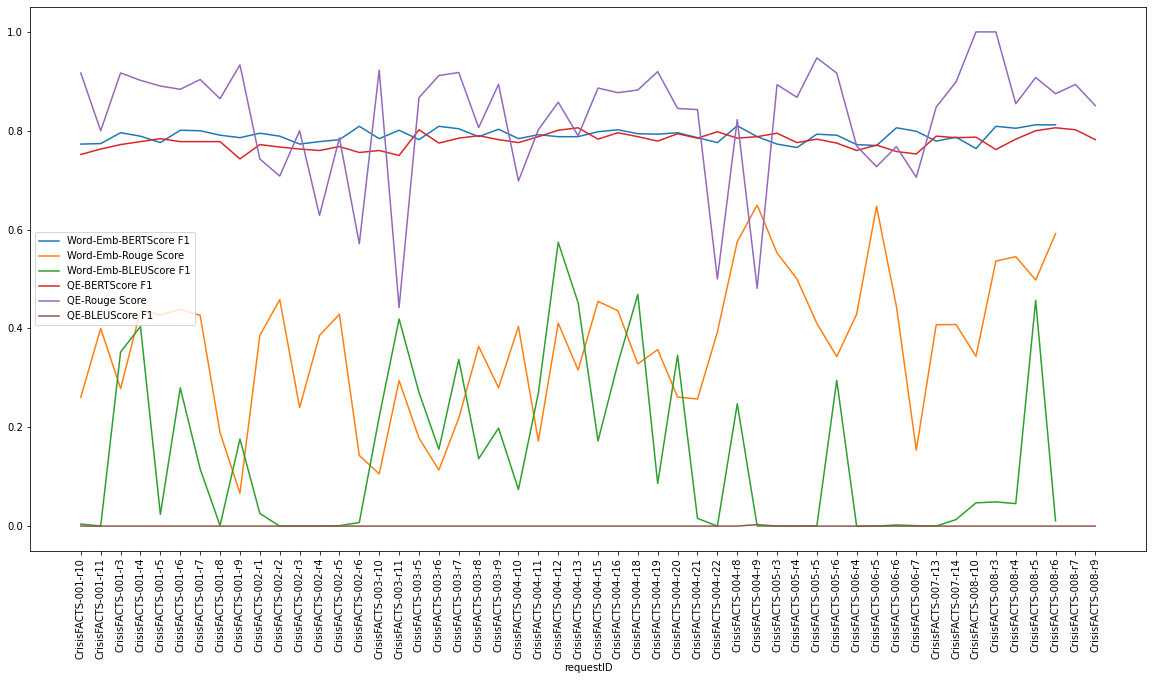

In [ ]:
import matplotlib.pyplot as plt

ax = dataw2v.plot(x="requestID", y=["BERTScore F1", "Rouge Score", "BLEU Score"],figsize=(20,10))
dataqe.plot(x="requestID", y=["BERTScore F1", "Rouge Score", "BLEU Score"],figsize=(20,10),ax=ax)
plt.xticks(range(0,len(dataqe.requestID)), dataqe.requestID, rotation=90)
L=plt.legend()
L.get_texts()[0].set_text('Word-Emb-BERTScore F1')
L.get_texts()[1].set_text('Word-Emb-Rouge Score')
L.get_texts()[2].set_text('Word-Emb-BLEUScore F1')
L.get_texts()[3].set_text('QE-BERTScore F1')
L.get_texts()[4].set_text('QE-Rouge Score')
L.get_texts()[5].set_text('QE-BLEUScore F1')
plt.show()

In [ ]:
dataqe.head()

,Unnamed: 0,requestID,BERTScore F1,Rouge Score,BLEU Score
0,0,CrisisFACTS-001-r10,0.752,0.916667,0.000000e+00
1,1,CrisisFACTS-001-r11,0.763,0.800000,0.000000e+00
2,2,CrisisFACTS-001-r3,0.772,0.917023,3.681483e-08
3,3,CrisisFACTS-001-r4,0.778,0.901984,3.792875e-33
4,4,CrisisFACTS-001-r5,0.784,0.890511,4.240178e-119


<BarContainer object of 52 artists>

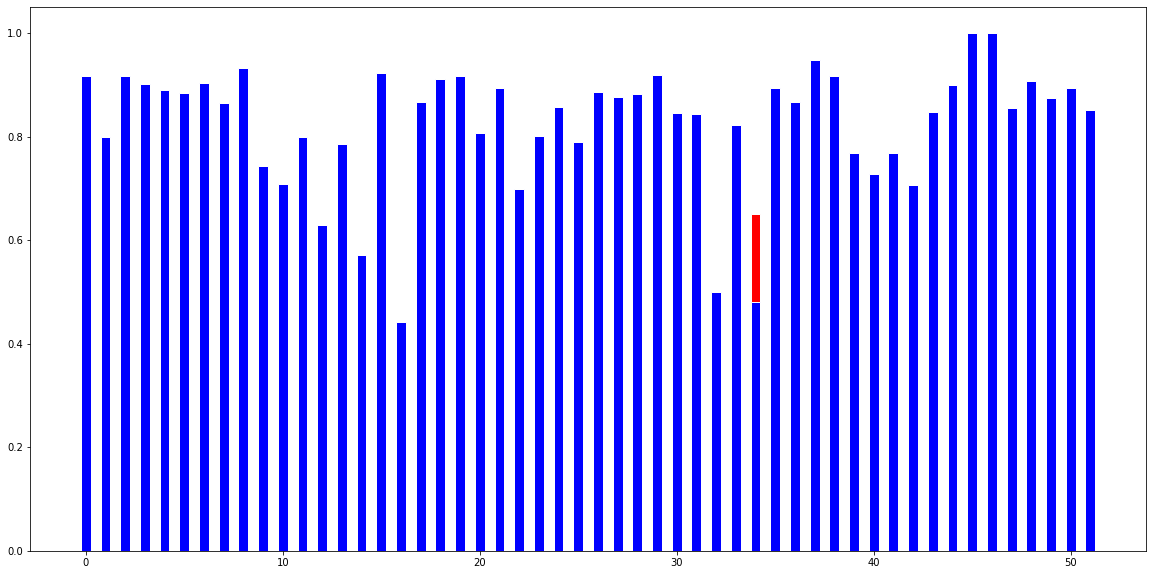

In [ ]:

barWidth = 0.5
plt.figure(figsize=(20,10))
plt.bar(num1, dataw2v['Rouge Score'].values.flatten(), color='#FF0000',edgecolor='white',width=barWidth)
plt.bar(num2, dataqe['Rouge Score'].values.flatten(), color='#0000FF',edgecolor='white',width=barWidth)

([<matplotlib.axis.XTick at 0x7f1041903b10>,
 [Text(0, 0, 'CrisisFACTS-001-r10'),
  Text(0, 0, 'CrisisFACTS-001-r11'),
  Text(0, 0, 'CrisisFACTS-001-r3'),
  Text(0, 0, 'CrisisFACTS-001-r4'),
  Text(0, 0, 'CrisisFACTS-001-r5'),
  Text(0, 0, 'CrisisFACTS-001-r6'),
  Text(0, 0, 'CrisisFACTS-001-r7'),
  Text(0, 0, 'CrisisFACTS-001-r8'),
  Text(0, 0, 'CrisisFACTS-001-r9'),
  Text(0, 0, 'CrisisFACTS-002-r1'),
  Text(0, 0, 'CrisisFACTS-002-r2'),
  Text(0, 0, 'CrisisFACTS-002-r3'),
  Text(0, 0, 'CrisisFACTS-002-r4'),
  Text(0, 0, 'CrisisFACTS-002-r5'),
  Text(0, 0, 'CrisisFACTS-002-r6'),
  Text(0, 0, 'CrisisFACTS-003-r10'),
  Text(0, 0, 'CrisisFACTS-003-r11'),
  Text(0, 0, 'CrisisFACTS-003-r5'),
  Text(0, 0, 'CrisisFACTS-003-r6'),
  Text(0, 0, 'CrisisFACTS-003-r7'),
  Text(0, 0, 'CrisisFACTS-003-r8'),
  Text(0, 0, 'CrisisFACTS-003-r9'),
  Text(0, 0, 'CrisisFACTS-004-r10'),
  Text(0, 0, 'CrisisFACTS-004-r11'),
  Text(0, 0, 'CrisisFACTS-004-r12'),
  Text(0, 0, 'CrisisFACTS-004-r13'),
  Text(0, 0

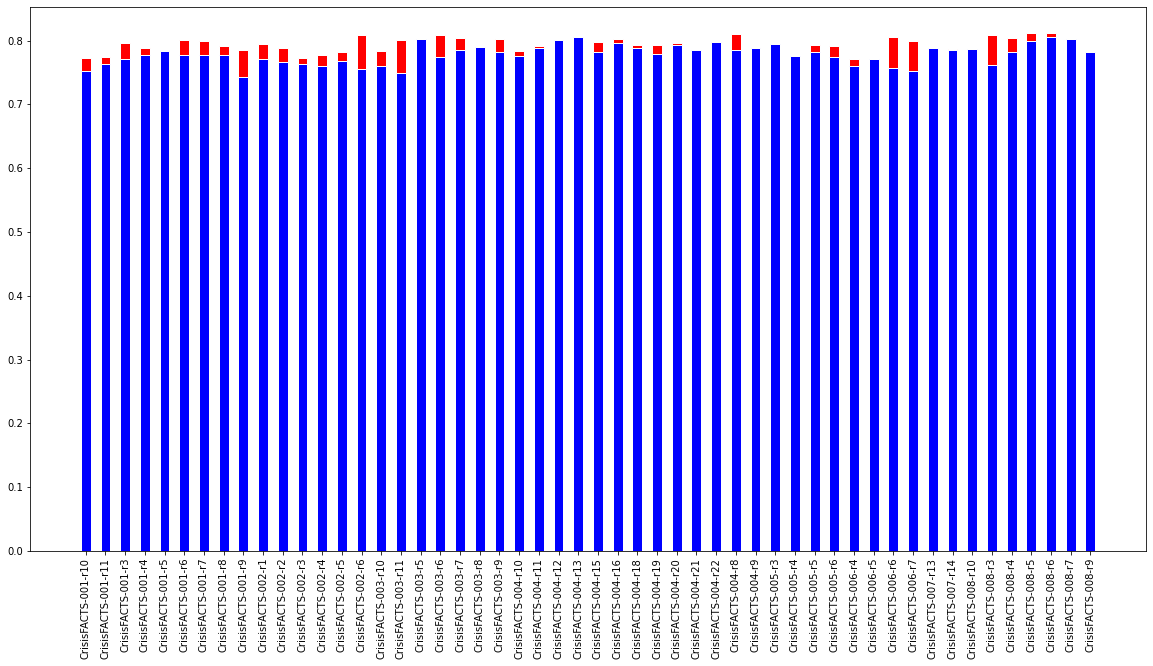

In [ ]:
num1 = list(dataw2v.index)
num2 = list(dataqe.index)

plt.bar(num1, dataw2v['BERTScore F1'].values.flatten(), color='#FF0000',edgecolor='white',width=barWidth)
plt.bar(num2, dataqe['BERTScore F1'].values.flatten(), color='#0000FF',edgecolor='white',width=barWidth)
plt.xticks(range(0,len(dataqe.requestID)), dataqe.requestID, rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51]), <a list of 52 Text major ticklabel objects>)

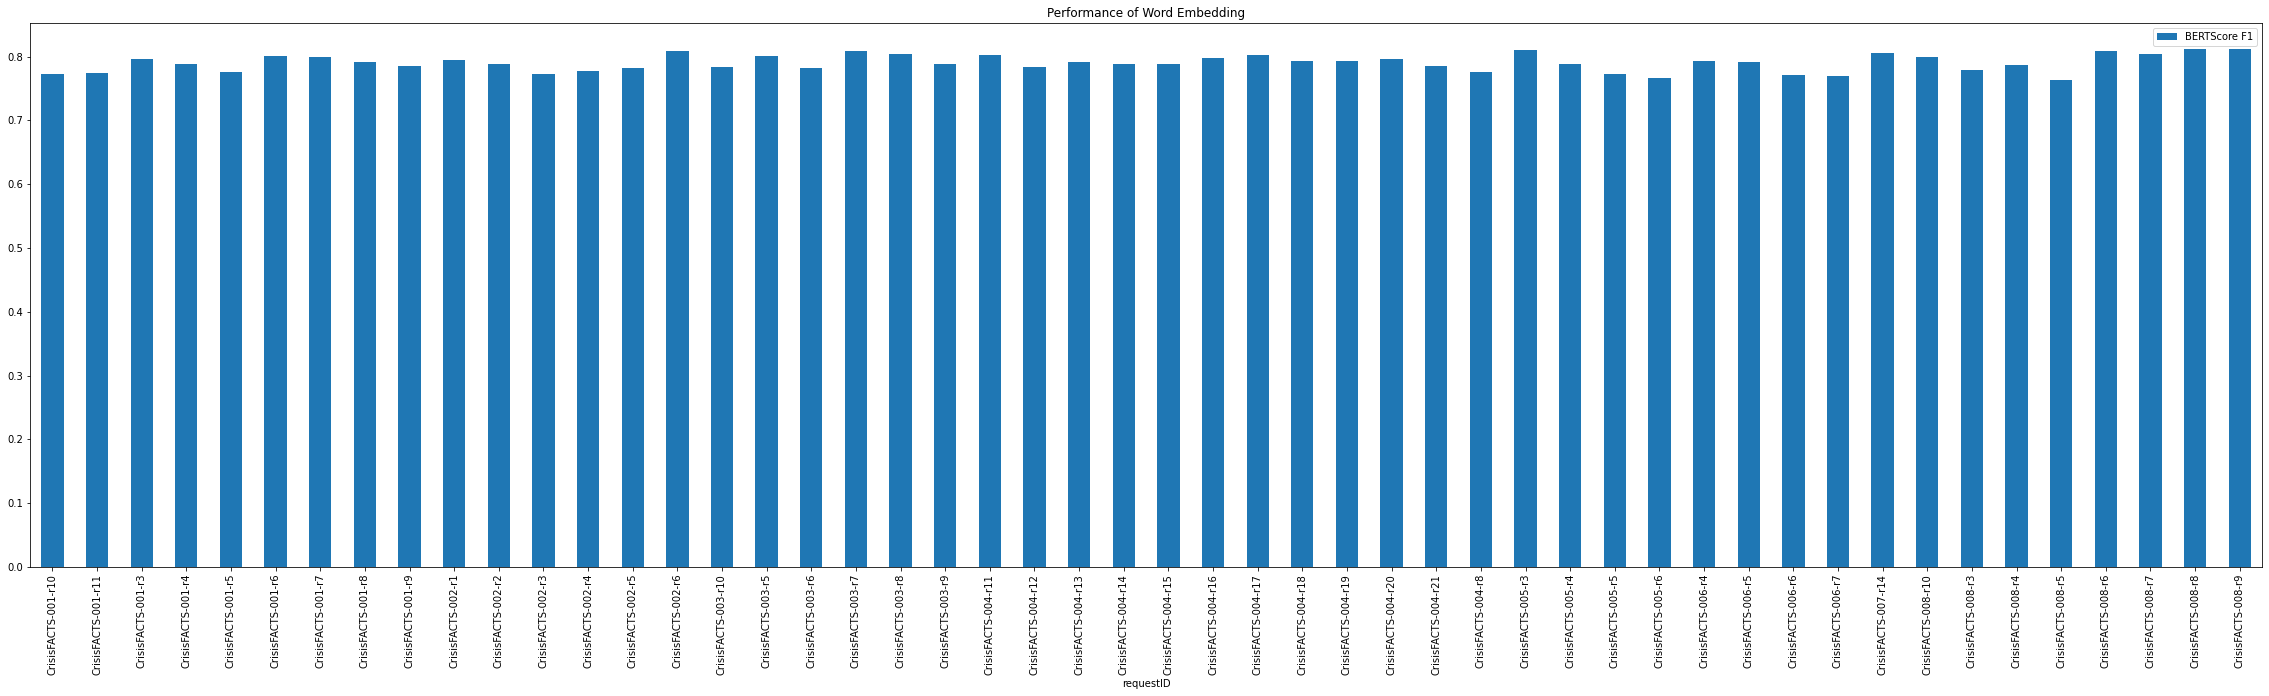

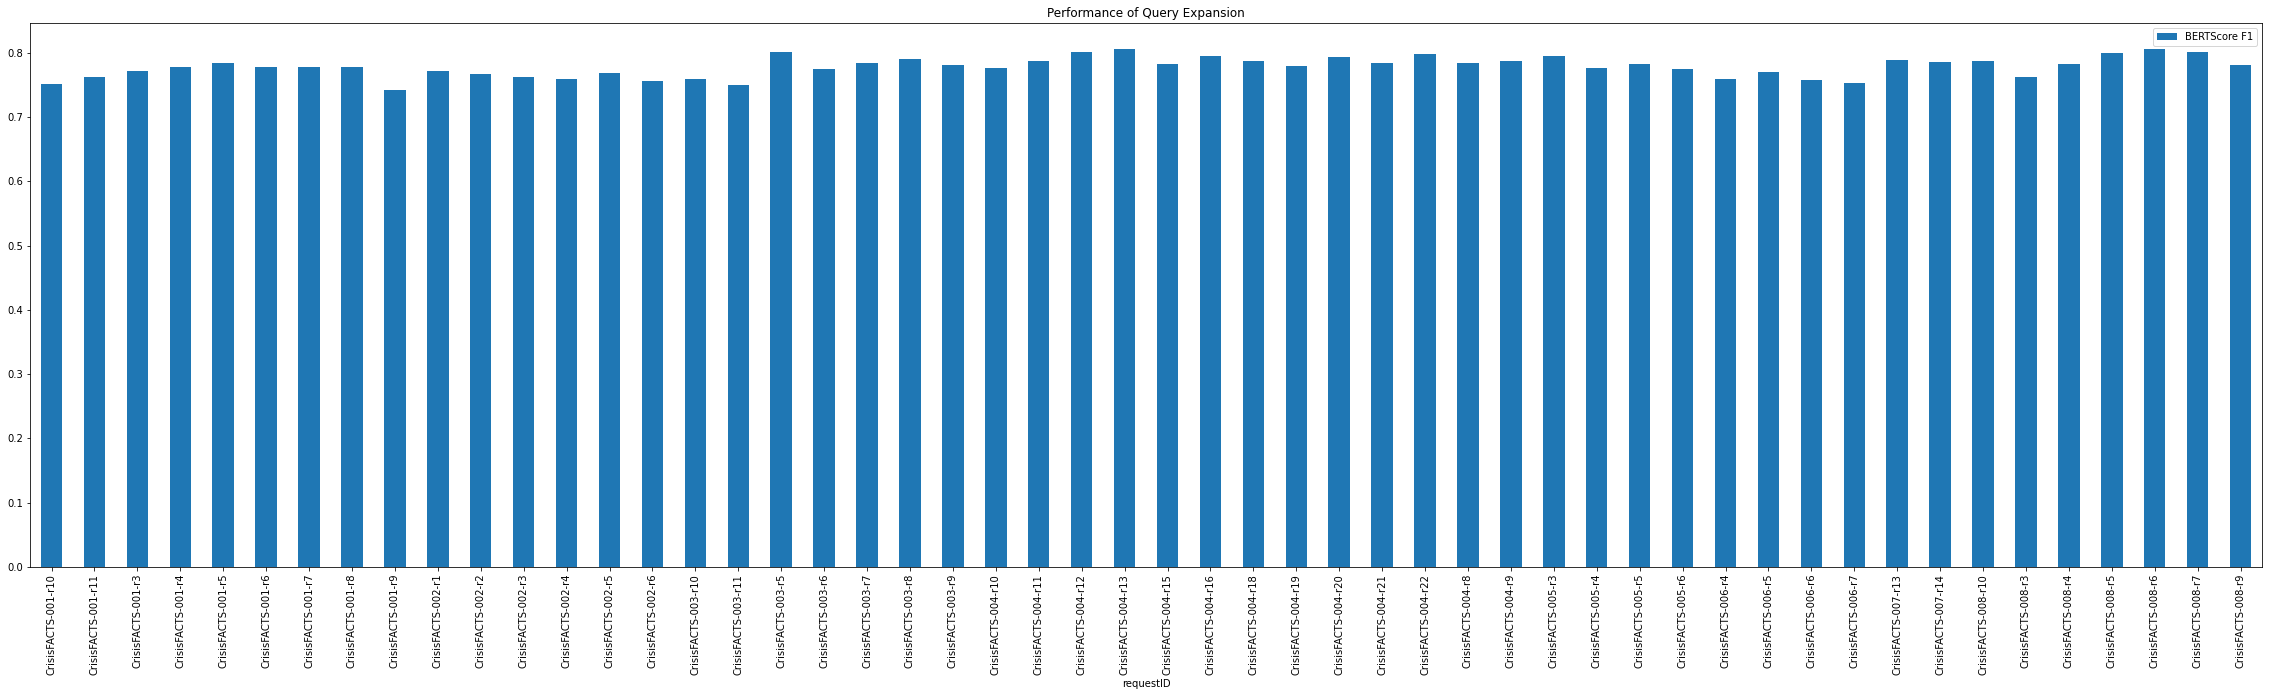

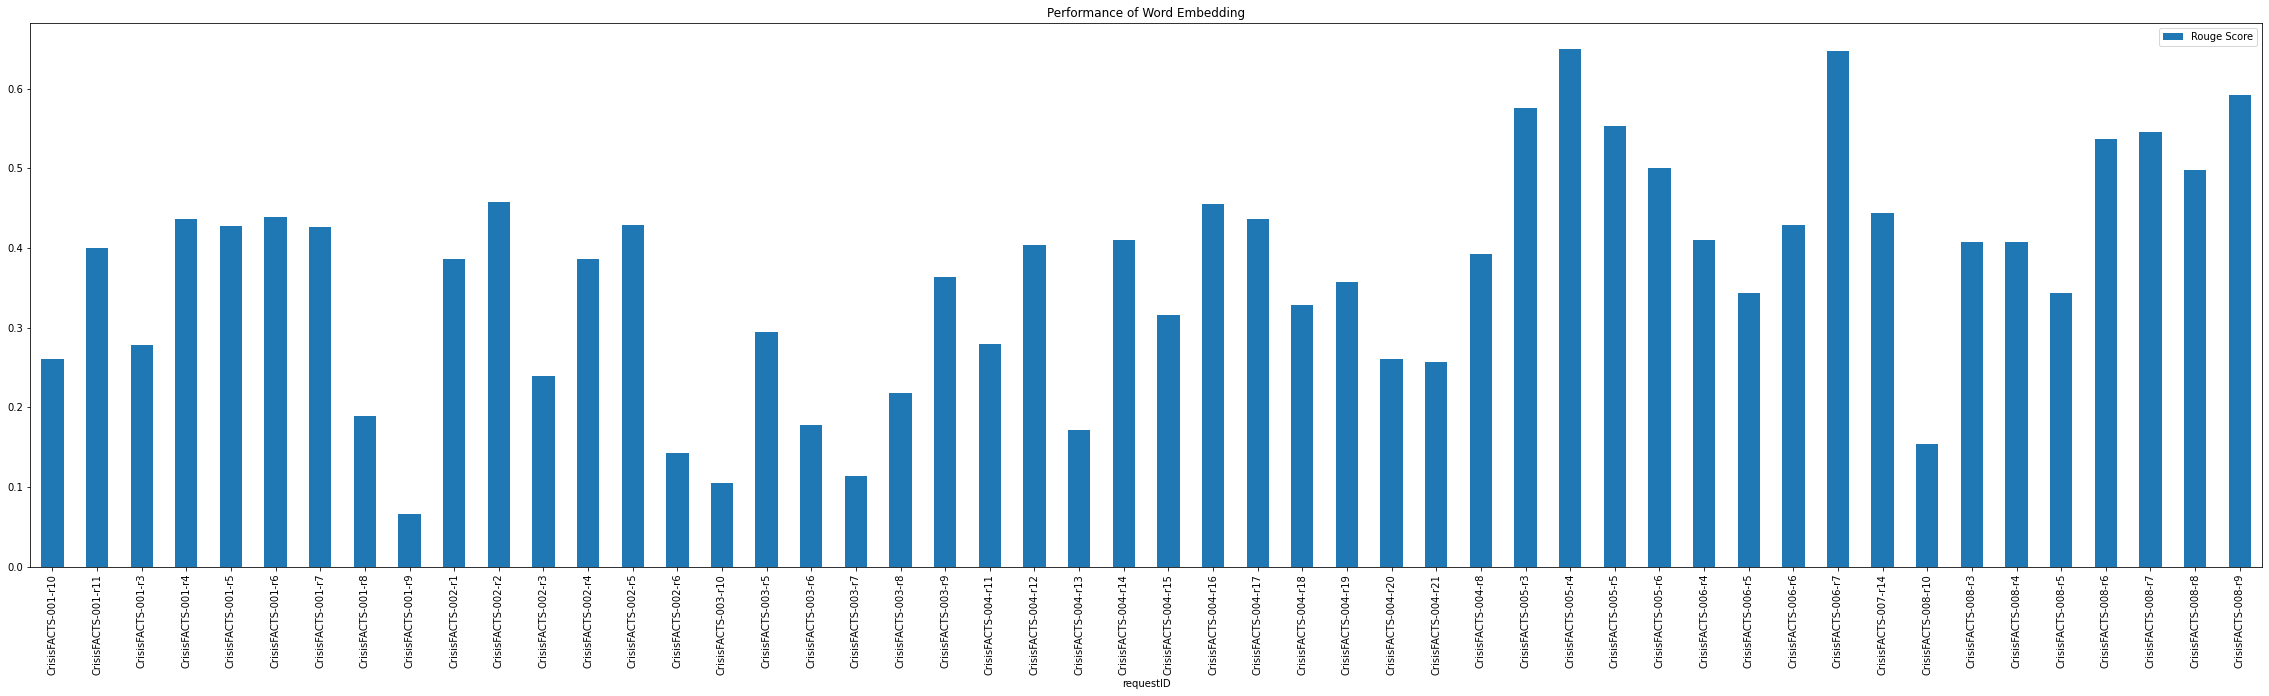

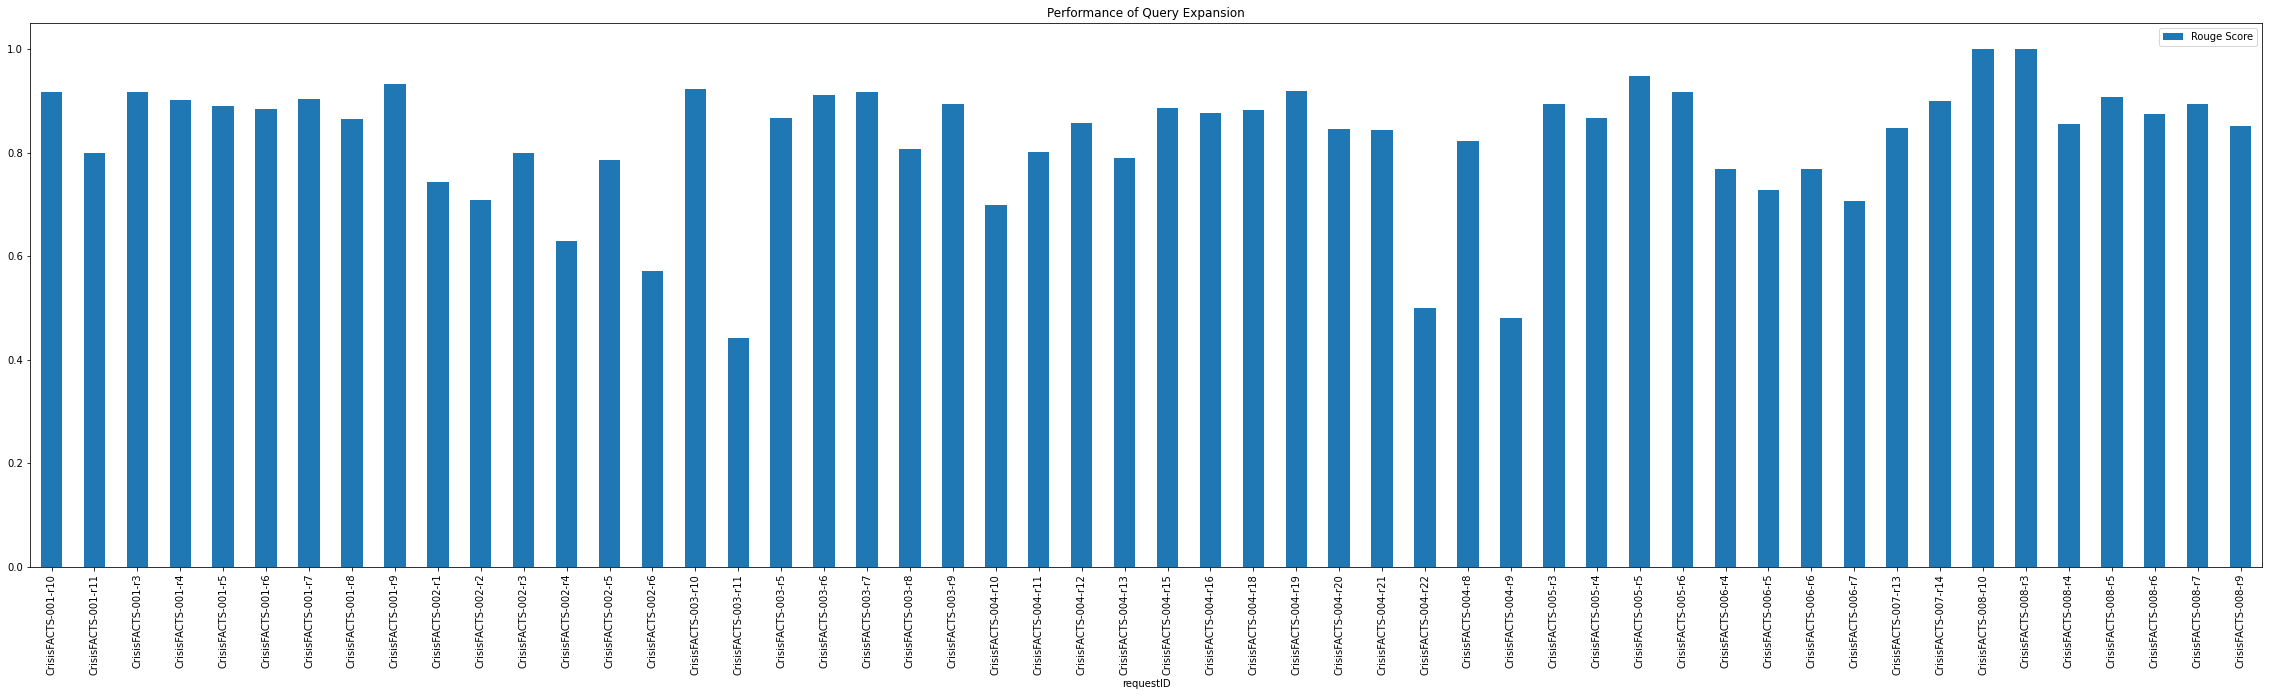

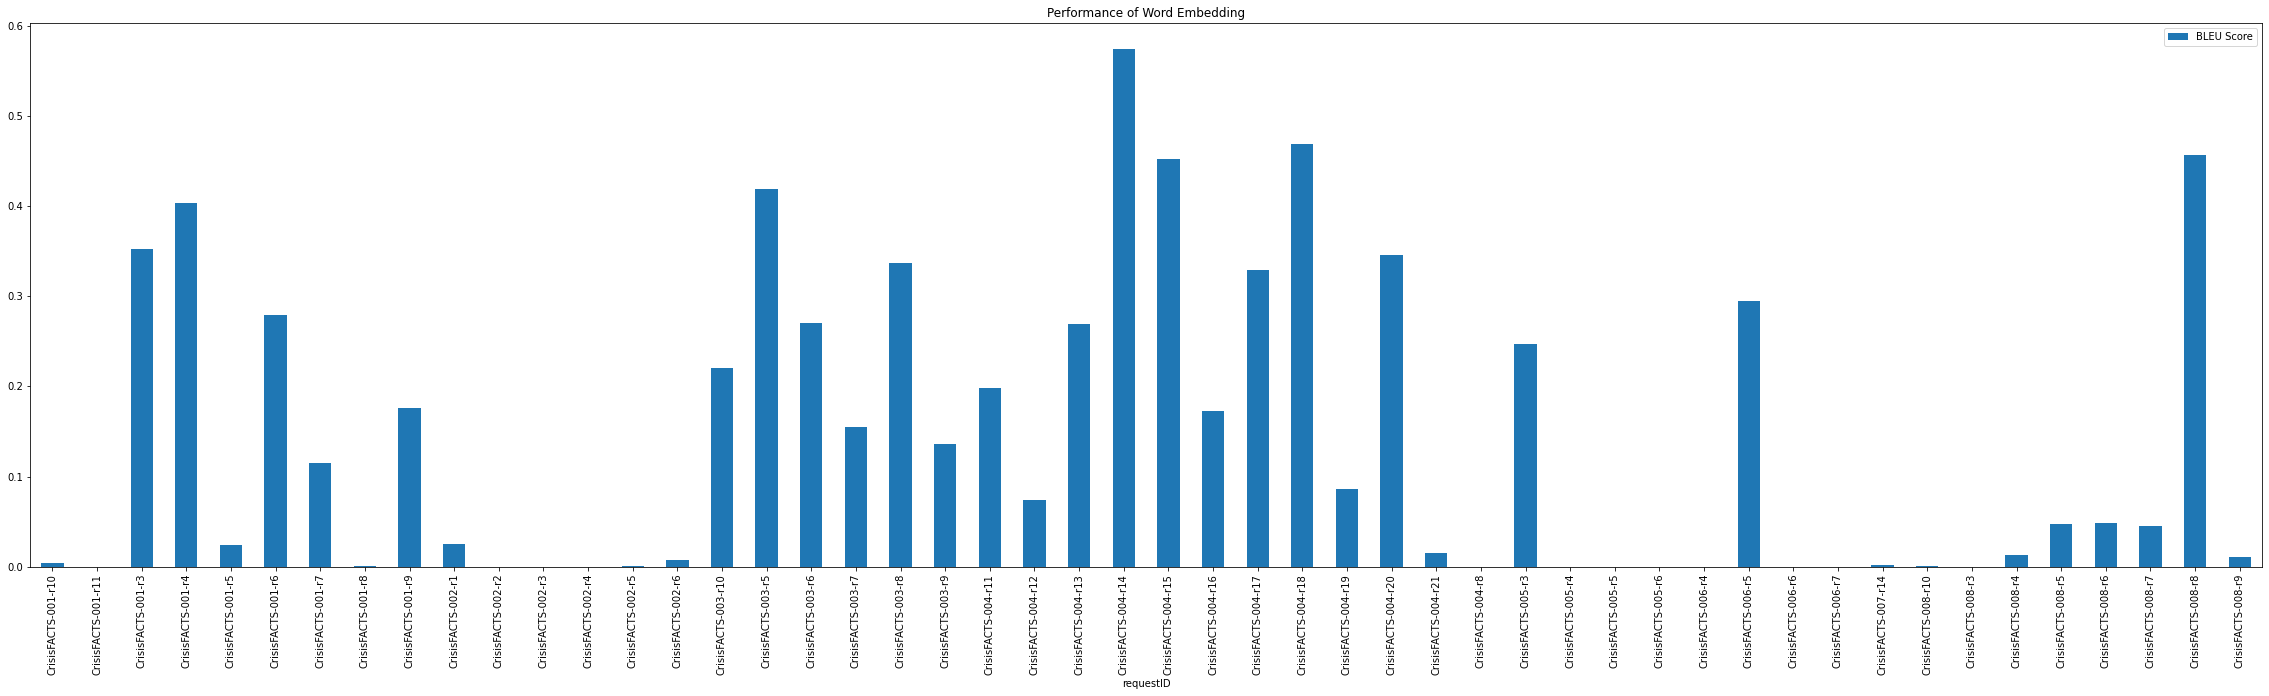

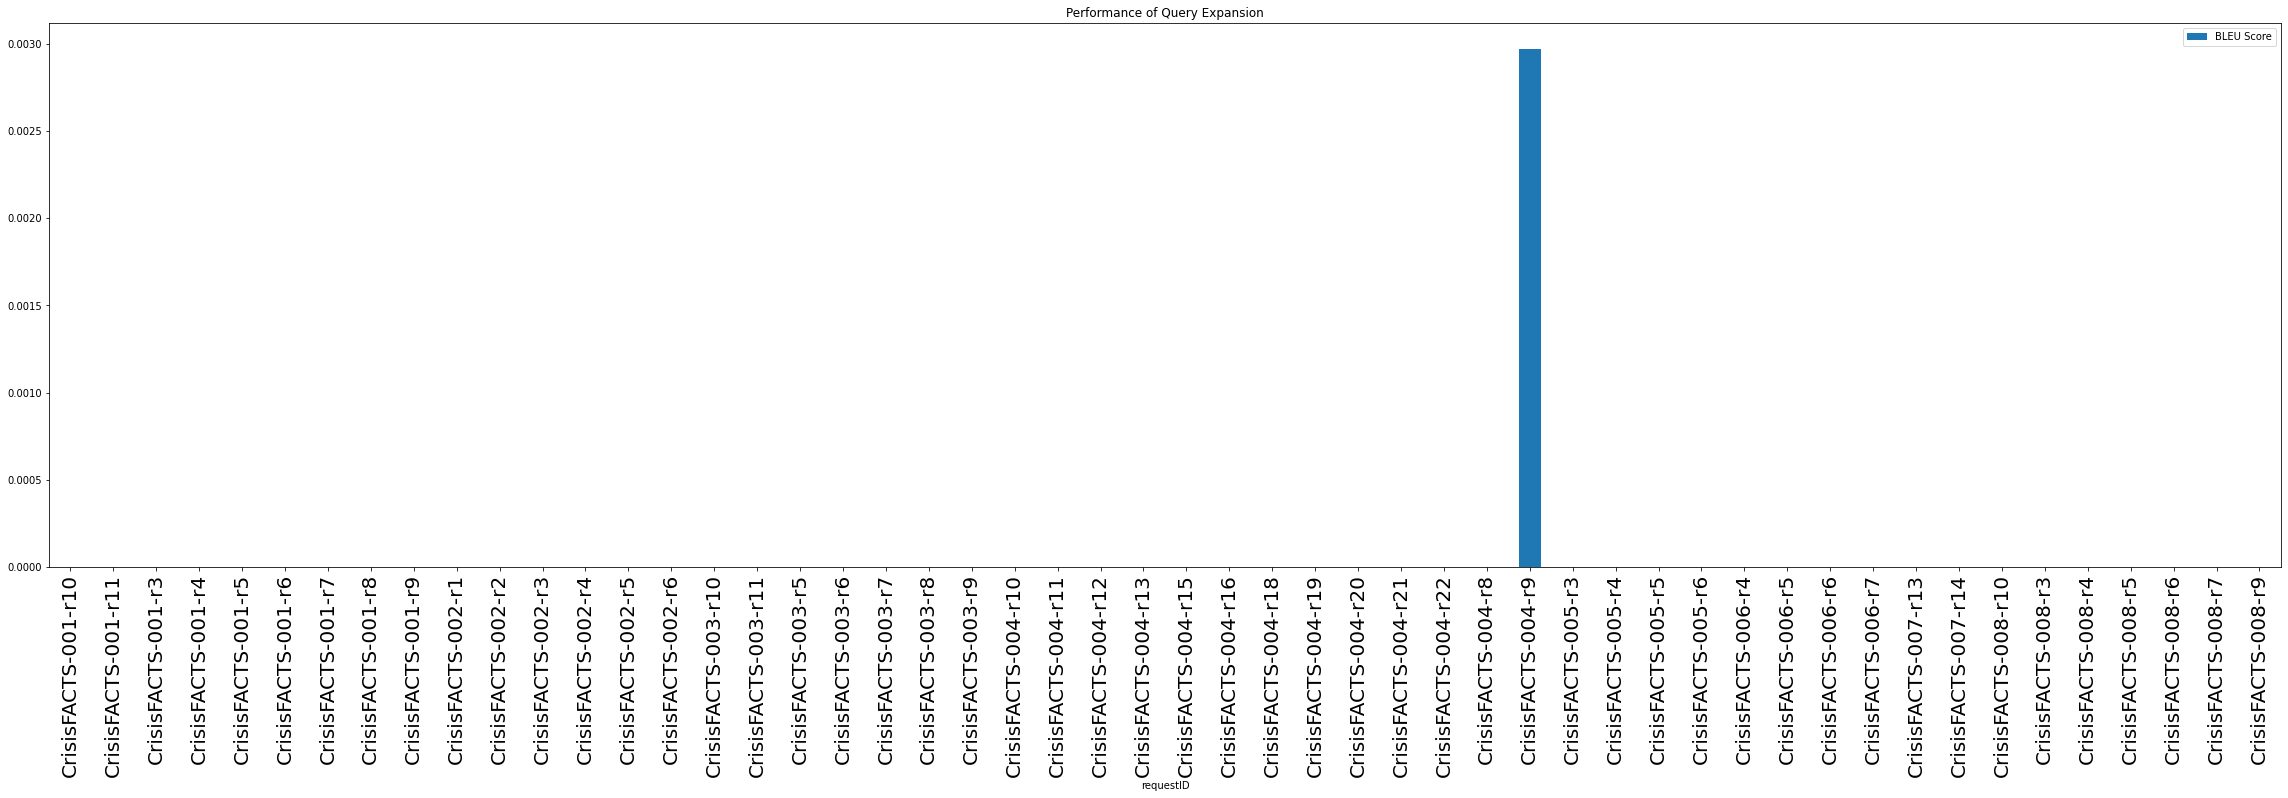

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
  
dataw2v.plot(x="requestID", y=["BERTScore F1"], kind="bar", width=0.5,figsize=(40,10), title="Performance of Word Embedding")
dataqe.plot(x="requestID", y=["BERTScore F1"], kind="bar", width=0.5,figsize=(40,10),  title="Performance of Query Expansion")
dataw2v.plot(x="requestID", y=["Rouge Score"], kind="bar", width=0.5,figsize=(40,10), title="Performance of Word Embedding")
dataqe.plot(x="requestID", y=["Rouge Score"], kind="bar", width=0.5,figsize=(40,10),  title="Performance of Query Expansion")
dataw2v.plot(x="requestID", y=["BLEU Score"], kind="bar", width=0.5,figsize=(40,10), title="Performance of Word Embedding")
dataqe.plot(x="requestID", y=["BLEU Score"], kind="bar", width=0.5,figsize=(40,10),  title="Performance of Query Expansion")

plt.xticks(fontsize=20)

In [ ]:
def avgCalculationByEvents(dataframe):
  eventlist = pd.DataFrame()
  eventlist["Events"] = dataframe.requestID.str[:15]
  eventlist["AvgBERTScore"] = dataw2v["BERTScore F1"]
  eventlist["AvgRougeScore"] = dataw2v["Rouge Score"]
  eventlist["AvgBLEUcore"] = dataw2v["BLEU Score"]
  finalevents = eventlist.groupby('Events', as_index=False)['AvgBERTScore','AvgRougeScore','AvgBLEUcore'].mean()
  return finalevents

In [ ]:
pd.DataFrame(avgCalculationByEvents(dataw2v)).T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,0,1,2,3,4,5,6,7
Events,CrisisFACTS-001,CrisisFACTS-002,CrisisFACTS-003,CrisisFACTS-004,CrisisFACTS-005,CrisisFACTS-006,CrisisFACTS-007,CrisisFACTS-008
AvgBERTScore,0.787333,0.787667,0.794667,0.791667,0.78425,0.7815,0.806,0.795875
AvgRougeScore,0.324854,0.340198,0.212305,0.339087,0.569481,0.457215,0.444444,0.43548
AvgBLEUcore,0.15075,0.005613,0.256538,0.248771,0.061919,0.073793,0.00222,0.077883


In [ ]:
pd.DataFrame(avgCalculationByEvents(dataw2v).mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


,0
AvgBERTScore,0.791120
AvgRougeScore,0.390383
AvgBLEUcore,0.109686


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


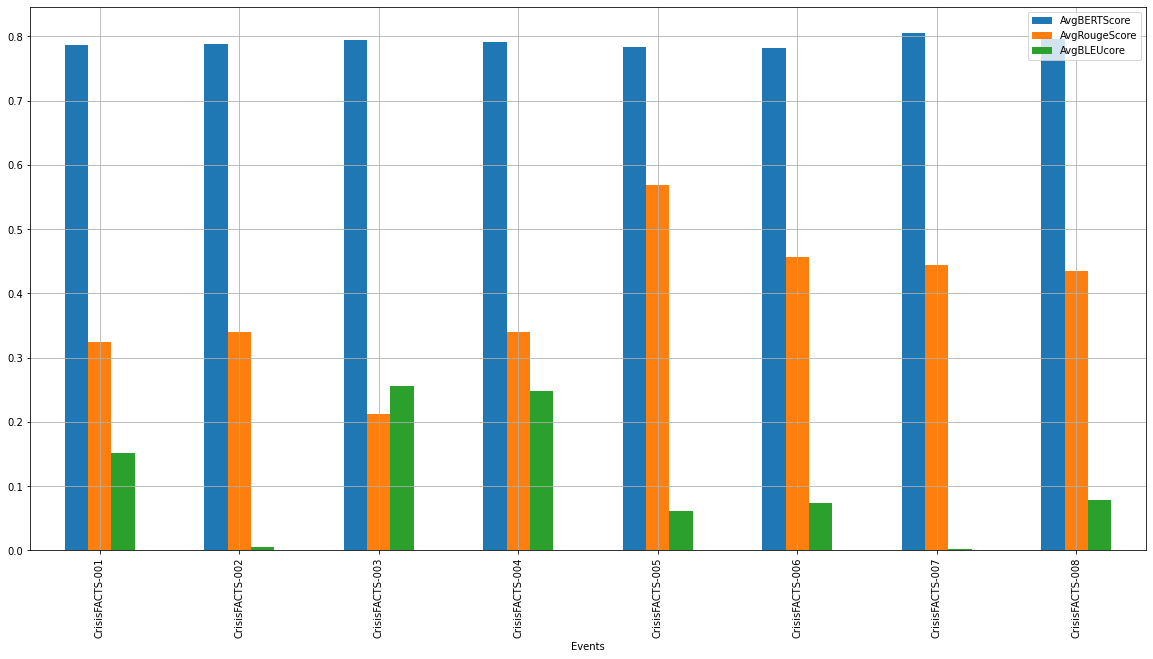

In [ ]:
avgCalculationByEvents(dataw2v).plot(x='Events', y=['AvgBERTScore','AvgRougeScore','AvgBLEUcore'],kind="bar", figsize=(20,10), grid=True, title="Performance of Query Embedding")

In [ ]:
pd.DataFrame(avgCalculationByEvents(dataqe)).T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,0,1,2,3,4,5,6,7
Events,CrisisFACTS-001,CrisisFACTS-002,CrisisFACTS-003,CrisisFACTS-004,CrisisFACTS-005,CrisisFACTS-006,CrisisFACTS-007,CrisisFACTS-008
AvgBERTScore,0.787333,0.787667,0.795857,0.791923,0.78075,0.78675,0.783,0.8004
AvgRougeScore,0.324854,0.340198,0.221975,0.385718,0.451466,0.41848,0.407651,0.502939
AvgBLEUcore,0.15075,0.005613,0.248206,0.23344,0.073793,0.00076,0.006646,0.121791


In [ ]:
pd.DataFrame(avgCalculationByEvents(dataqe).mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


,0
AvgBERTScore,0.789210
AvgRougeScore,0.381660
AvgBLEUcore,0.105125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


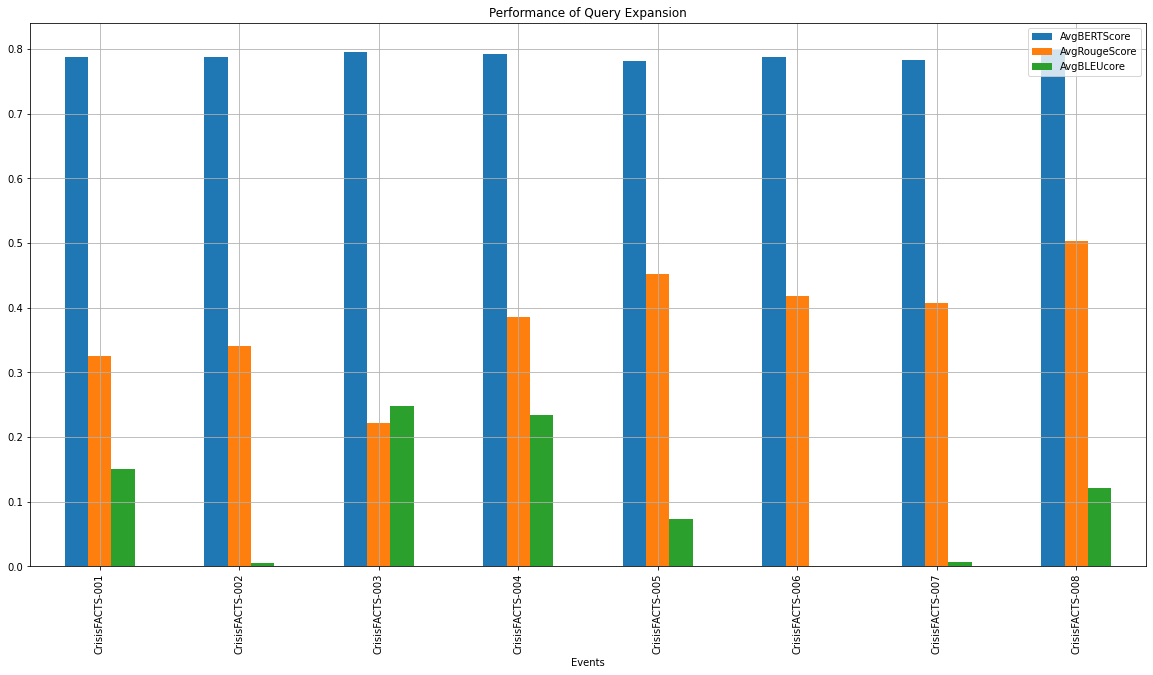

In [ ]:
avgCalculationByEvents(dataqe).plot(x='Events', y=['AvgBERTScore','AvgRougeScore','AvgBLEUcore'], kind='bar', figsize=(20,10), grid=True, title="Performance of Query Expansion")



---

